<h1 style="text-align:center">New York City Taxi Trip Duration</h1>

<h3 style="text-align:center">Load Libraries</h3>

In [1]:
import numpy as np
import pandas as pd

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from bokeh.plotting import figure, show 
from bokeh.charts import Donut, show
from bokeh.io import output_notebook
output_notebook()


Loading BokehJS ...

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h3 style="text-align:center">Load Dataset</h3>

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (1458644, 11)
Test set shape: (625134, 9)


<h3 style="text-align:center">Data exploration</h3>

In [5]:
# Observation of the first 5 elements in the training set
train_df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [6]:
# Check the types or each features
train_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Analyze missing data 

In [7]:
# print(train_df.isnull().sum(), "\n")
# print(test_df.isnull().sum())

pd.DataFrame( {'missing values(train set)': train_df.isnull().sum(),
              'missing values(test_set)' : test_df.isnull().sum() } )

missing values(test_set)  missing values(train set)
dropoff_datetime                         NaN                          0
dropoff_latitude                         0.0                          0
dropoff_longitude                        0.0                          0
id                                       0.0                          0
passenger_count                          0.0                          0
pickup_datetime                          0.0                          0
pickup_latitude                          0.0                          0
pickup_longitude                         0.0                          0
store_and_fwd_flag                       0.0                          0
trip_duration                            NaN                          0
vendor_id                                0.0                          0

There's no missing data in both the train and test dataframe

<u>Target Feature</u>

In [8]:
# pd.options.display.float_format = '{:,.2f}'.format
train_df['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

Let's observe the skewness of the trip duration

In [9]:
train_df['trip_duration'].skew()

343.1639435917362

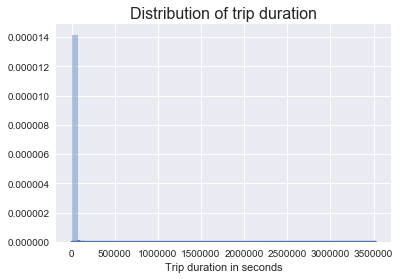

In [10]:
sns.distplot(train_df['trip_duration'])
plt.title("Distribution of trip duration", size=16)
plt.xlabel("Trip duration in seconds")
plt.show()

In regression problems, it is important to look for the skewness of the target feature. <br>
In fact, algorithms such as linear regression or K-Nearest Neighbors are sensitive to the skewness of the data. <br>
The most common correction for a positive skew is to apply <i>the Log transform</i> to have a normally distributed variable.

Skew is: -0.340704230448


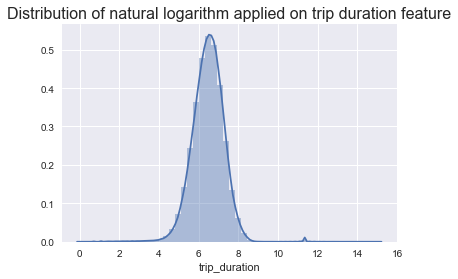

In [11]:
target = np.log(train_df['trip_duration'])
print("Skew is:", target.skew())
sns.distplot(target)
plt.title("Distribution of natural logarithm applied on trip duration feature", size=16)
plt.show()

For the sake of meaningful visualization, we store the result in another variable so that we will be able to make use of it during the processing part.

<u>Correlation with trip duration</u>

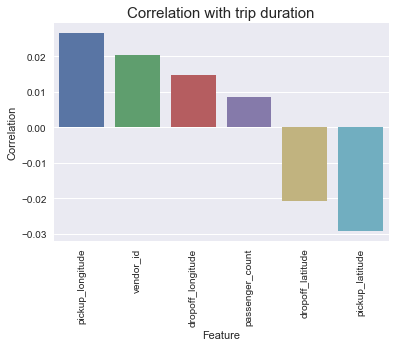

In [12]:
corr = train_df.drop(['id'], axis=1).corr()
corr_df = pd.DataFrame(corr['trip_duration'].sort_values(ascending=False))[1:]
corr_df.columns = ['Correlation']
corr_df.index.name = 'Feature'

ax = sns.barplot(x=corr_df.index, y='Correlation', data=corr_df)
ax.set(ylabel='Correlation')
plt.xticks(rotation=90)
plt.title('Correlation with trip duration', size=15)
plt.show()

We observe that there is not strong relation with the trip duration and the actual numerical features. <br>
We need to feature engineering the string features to establish a new correlation plot as we might infer something more interesting.

<h3 style="text-align:center">Data Cleaning</h3>

In [13]:
pd.DataFrame( {'passenger_count (train set)': train_df['passenger_count'].value_counts(),
              'passenger_count (test_set)' : test_df['passenger_count'].value_counts()} )

passenger_count (test_set)  passenger_count (train set)
0                        23.0                           60
1                    443447.0                      1033540
2                     90027.0                       210318
3                     25686.0                        59896
4                     12017.0                        28404
5                     33411.0                        78088
6                     20521.0                        48333
7                         NaN                            3
8                         NaN                            1
9                         2.0                            1

We will treat values with 0 passenger_count to 1. <br>

In [14]:
def clean_passenger_count(dataset):
    dataset.loc[ dataset['passenger_count'] == 0, 'passenger_count' ] = 1

clean_passenger_count(train_df)
clean_passenger_count(test_df)

In [15]:
train_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [16]:
# Pie chart with Bokeh
pie_chart = Donut(train_df['passenger_count'].value_counts())
show(pie_chart)

<u>Trip duration</u>

In [17]:
train_df.loc[ train_df['trip_duration'] > 80000, : ].shape

(1899, 11)

About 1900 trips accounted a trip duration of about 80000s, which is nearly 1 day! <br>

In [18]:
train_df.loc[ train_df['trip_duration'] > 70000, : ].head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
531   id3307903          2  2016-02-20 04:03:06  2016-02-21 03:33:00   
1134  id1091477          2  2016-05-07 18:36:22  2016-05-08 18:32:11   
1865  id3431345          2  2016-06-07 12:58:48  2016-06-08 12:58:00   
3442  id1487069          2  2016-02-13 00:21:49  2016-02-14 00:19:05   
4172  id3674870          2  2016-03-18 11:54:20  2016-03-19 11:34:17   

      passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
531                 3        -74.008102        40.741489         -74.009956   
1134                1        -73.990242        40.750919         -73.976280   
1865                6        -73.954956        40.777649         -73.981033   
3442                1        -73.968590        40.799217         -73.979584   
4172                1        -73.989090        40.736992         -73.972336   

      dropoff_latitude store_and_fwd_flag  trip_duration  
531          40.714611                  N          84594  
1134         40.750889                  N          86149  
1865         40.743713                  N          86352  
3442         40.784714                  N          86236  
4172         40.751511                  N          85197

<h3 style="text-align:center">Feature Engineering</h3>

In [19]:
train_df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [20]:
# convert feature to datetime
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], \
                    format="%Y-%m-%d %H:%M:%S") 

# Extract weekday number (from Monday=0 to Sunday=6)
train_df['DayOfWeekNum'] = train_df['pickup_datetime'].dt.dayofweek

# Extract Month 
train_df['Month'] = train_df['pickup_datetime'].dt.month

# Extract the Month's day from 0 to 31
train_df['DayOfMonth'] = train_df['pickup_datetime'].dt.day

# Extract the Hour of the day
train_df['HourOfDay'] = train_df['pickup_datetime'].dt.hour


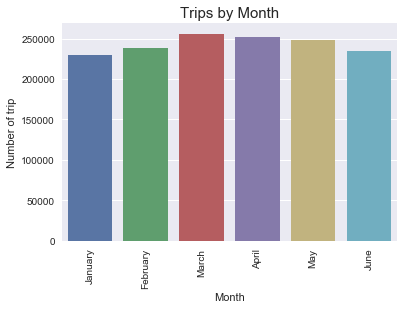

In [21]:
fig, ax = plt.subplots()

sns.countplot(x='Month', 
             data=train_df)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['January', 'February', 'March', 'April', 'May', 'June']

ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.title('Trips by Month', size=15)
plt.ylabel('Number of trip')

plt.show()

Interestingly, the data provided only offers the trips of the first half of 2016. <br>
Furthermore, we observe that March was the most successful month in terms of number of trips. <br>
On the other hand January is not as successful, probably due to the fact that January is usually the coldest month of the year for New York.

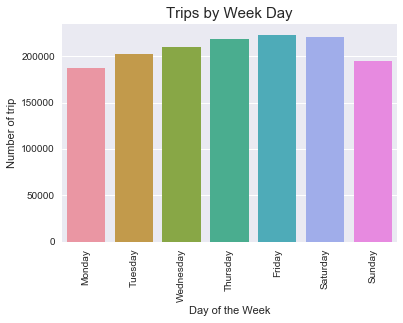

In [22]:
fig, ax = plt.subplots()

sns.countplot(x='DayOfWeekNum',
              data=train_df)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', \
         'Friday', 'Saturday', 'Sunday']

ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.title('Trips by Week Day', size=15)
plt.xlabel('Day of the Week')
plt.ylabel('Number of trip')


plt.show()

This previous plot display how the traffic of taxis is doing during the weeks. <br>
Friday seems to be the most profitable day with Saturday while Sunday and Monday are the less demanding of taxis.

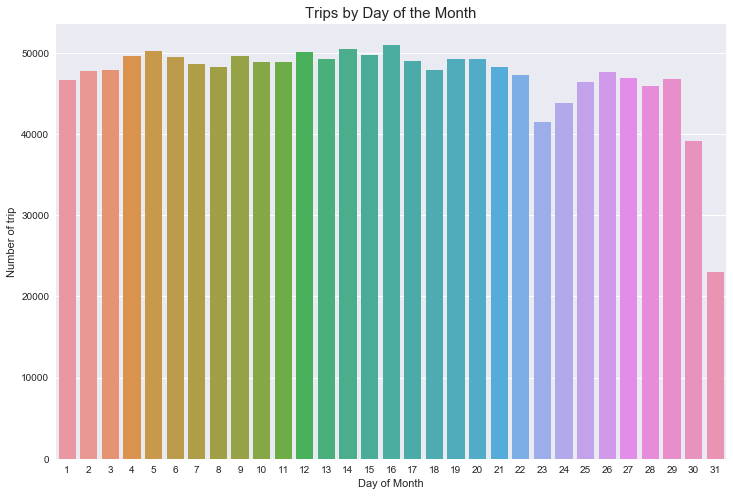

In [23]:
plt.figure(figsize=(12,8))

sns.countplot(x='DayOfMonth',
             data=train_df)

plt.title('Trips by Day of the Month', size=15)
plt.xlabel('Day of Month')
plt.ylabel('Number of trip')

plt.show()

The repartition is quite well distributed. <br>
One might notice that the 31st there is way less trips but that is due to the fact there is way less 31st number in the year. <br>
In 2016, only January, March and May had 31 days in the first half of the year. <br>
Days with 31 days also include day 30 so end of months are quite low regarding number of trips from taxis comparing to other days.

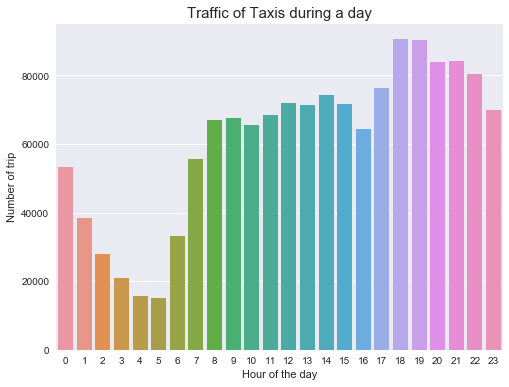

In [24]:
plt.figure(figsize=(8,6))

sns.countplot(x='HourOfDay',
           data=train_df)

plt.title('Traffic of Taxis during a day', size=15)
plt.xlabel('Hour of the day')
plt.ylabel('Number of trip')

plt.show()

Clearly from this plot we can infer that peak times are [6pm : 7pm] and off-peak times are [4am : 5pm].
From 6am the trend is growing up to 7pm. And past this hour, the trend is going the other way.

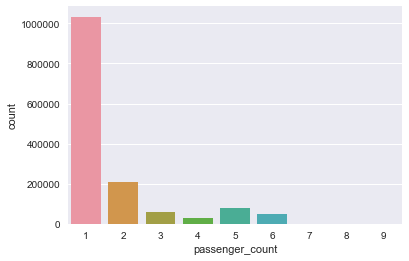

In [25]:
sns.countplot(train_df['passenger_count'])

<u>Passenger count</u>

In [26]:
train_df['passenger_count'].value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
7          3
9          1
8          1
Name: passenger_count, dtype: int64

We will group the number of passenger to be less sparse.

In [27]:
def transform_passenger_count(dataset):
    dataset.loc[ dataset['passenger_count'] >= 3, 'passenger_count' ] = 3
    
transform_passenger_count(train_df)
transform_passenger_count(test_df)

# train_df.loc[ train_df['passenger_count'] >= 3, 'passenger_count' ] = 3

In [28]:
# Pie chart with Bokeh
pie_chart = Donut(train_df['passenger_count'].value_counts())
show(pie_chart)

<u>Distance in miles</u>

In [29]:
train_df.head()

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  DayOfWeekNum  Month  \
0         40.765602                  N            455             0      3   
1         40.731152                  N            663             6      6   
2         40.710087                  N           2124             1      1   
3         40.706718                  N            429             2      4   
4         40.782520                  N            435             5      3   

   DayOfMonth  HourOfDay  
0          14         17  
1          12          0  
2          19         11  
3           6         19  
4          26         13

In [30]:
from geopy.distance import great_circle

def distance_calc(row):
    pickup  = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    
    return great_circle(pickup, dropoff).km

def get_distance(dataset):
    dataset['distance'] = dataset.apply(lambda row: distance_calc(row), axis=1)
    dataset.drop(['pickup_latitude', 'pickup_longitude', \
                  'dropoff_latitude','dropoff_longitude'], 
                   axis=1,
                   inplace=True)
    
# train_df['distance'] = train_df.apply(lambda row: distance_calc(row), axis=1)

get_distance(train_df)
get_distance(test_df)

In [31]:
test_df.head()

id  vendor_id      pickup_datetime  passenger_count  \
0  id3004672          1  2016-06-30 23:59:58                1   
1  id3505355          1  2016-06-30 23:59:53                1   
2  id1217141          1  2016-06-30 23:59:47                1   
3  id2150126          2  2016-06-30 23:59:41                1   
4  id1598245          1  2016-06-30 23:59:33                1   

  store_and_fwd_flag  distance  
0                  N  2.747200  
1                  N  2.760016  
2                  N  1.306523  
3                  N  5.270572  
4                  N  0.961113

<u>Datetime</u>

In the same way when we try to get information out off the pickup_datetime feature, we will extend this to the dropoff datetime and apply the same transformation to the test set.

In [32]:
train_df.head()

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  DayOfWeekNum  Month  \
0         40.765602                  N            455             0      3   
1         40.731152                  N            663             6      6   
2         40.710087                  N           2124             1      1   
3         40.706718                  N            429             2      4   
4         40.782520                  N            435             5      3   

   DayOfMonth  HourOfDay  
0          14         17  
1          12          0  
2          19         11  
3           6         19  
4          26         13

In [33]:
train_df.drop(['DayOfWeekNum', 'Month', 'DayOfMonth', 'HourOfDay'], axis=1, inplace=True)

In [44]:
def transform_datetime(dataset):
    # convert column to datetime type
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'], \
                    format="%Y-%m-%d %H:%M:%S")
    
    dataset['dropoff_datetime'] = pd.to_datetime(dataset['dropoff_datetime'], \
                    format="%Y-%m-%d %H:%M:%S")
    
    # Extract weekday number (from Monday=0 to Sunday=6)
    dataset['Pickup_NumDayWeek'] = dataset['pickup_datetime'].dt.dayofweek
    dataset['Dropoff_NumDayWeek'] = dataset['dropoff_datetime'].dt.dayofweek 
    
    # Extract Month 
    dataset['Month'] = dataset['pickup_datetime'].dt.month
    
    # Extract the Month's pickup day from 0 to 31
    dataset['Pickup_Day'] = dataset['pickup_datetime'].dt.day
    
    # Extract the Month's dropoff day from 0 to 31
    dataset['Dropoff_Day'] = dataset['dropoff_datetime'].dt.day    
    
    # Extract the pickup Hour/Minute/Seconds
    dataset['Pickup_Hour'] = dataset['pickup_datetime'].dt.hour
    dataset['Pickup_Minute'] = dataset['pickup_datetime'].dt.minute
    dataset['Pickup_Second'] = dataset['pickup_datetime'].dt.second
    
    # Extract the dropoff Hour/Minute/Seconds
    dataset['dropoff_Hour'] = dataset['dropoff_datetime'].dt.hour
    dataset['dropoff_Minute'] = dataset['dropoff_datetime'].dt.minute
    dataset['dropoff_Second'] = dataset['dropoff_datetime'].dt.second    
    
    dataset.drop( ['pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True )
    
transform_datetime(train_df)
transform_datetime(test_df)

In [45]:
train_df.head()

id  vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0  id2875421          2                1        -73.982155        40.767937   
1  id2377394          1                1        -73.980415        40.738564   
2  id3858529          2                1        -73.979027        40.763939   
3  id3504673          2                1        -74.010040        40.719971   
4  id2181028          2                1        -73.973053        40.793209   

   dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  \
0         -73.964630         40.765602                  N            455   
1         -73.999481         40.731152                  N            663   
2         -74.005333         40.710087                  N           2124   
3         -74.012268         40.706718                  N            429   
4         -73.972923         40.782520                  N            435   

   Name_Day_Week  Month  Pickup_Day  Dropoff_Day  Pickup_Hour  Pickup_Minute  \
0              0      3          14           14           17             24   
1              6      6          12           12            0             43   
2              1      1          19           19           11             35   
3              2      4           6            6           19             32   
4              5      3          26           26           13             30   

   dropoff_Hour  dropoff_Minute  Pickup_Second  dropoff_Second  
0            17              32             55              30  
1             0              54             35              38  
2            12              10             24              48  
3            19              39             31              40  
4            13              38             55              10

<u>store_and_fwd_flag</u>

In [47]:
train_df['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [48]:
test_df['store_and_fwd_flag'].value_counts()

N    621704
Y      3430
Name: store_and_fwd_flag, dtype: int64

In [50]:
def transform_store_and_fwd_flag(dataset):
    dataset['store_and_fwd_flag'] = dataset['store_and_fwd_flag'].map( {'Y': 1, 'N': 0} ).astype(int)

transform_store_and_fwd_flag(train_df)
transform_store_and_fwd_flag(test_df)

In [51]:
train_df.head()

id  vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0  id2875421          2                1        -73.982155        40.767937   
1  id2377394          1                1        -73.980415        40.738564   
2  id3858529          2                1        -73.979027        40.763939   
3  id3504673          2                1        -74.010040        40.719971   
4  id2181028          2                1        -73.973053        40.793209   

   dropoff_longitude  dropoff_latitude  store_and_fwd_flag  trip_duration  \
0         -73.964630         40.765602                   0            455   
1         -73.999481         40.731152                   0            663   
2         -74.005333         40.710087                   0           2124   
3         -74.012268         40.706718                   0            429   
4         -73.972923         40.782520                   0            435   

   Name_Day_Week  Month  Pickup_Day  Dropoff_Day  Pickup_Hour  Pickup_Minute  \
0              0      3          14           14           17             24   
1              6      6          12           12            0             43   
2              1      1          19           19           11             35   
3              2      4           6            6           19             32   
4              5      3          26           26           13             30   

   dropoff_Hour  dropoff_Minute  Pickup_Second  dropoff_Second  
0            17              32             55              30  
1             0              54             35              38  
2            12              10             24              48  
3            19              39             31              40  
4            13              38             55              10